# Visualize Real BLE data

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import IPython
import IPython.display

In [22]:
CSV_FILE_PATH = "../data/real_ble_data.csv"

### Load CSV as dataframe

In [23]:
df = pd.read_csv(CSV_FILE_PATH)
df

,address,packet_id,rssi,count,rx_speed,tx_speed,last_time_elapsed,total_time_elapsed,timestamp
0,[Recv] <<< 23:c9:cc:4b:a0:3a,20585,-32,1,65.00,65.00,49132,65,49132
1,[Recv] <<< 23:c9:cc:4b:a0:3a,20586,-35,2,53.50,53.50,42,107,49174
2,[Recv] <<< 23:c9:cc:4b:a0:3a,20587,-35,3,49.67,49.67,42,149,49216
3,[Recv] <<< 23:c9:cc:4b:a0:3a,20588,-41,4,47.00,47.00,39,188,49255
4,[Recv] <<< 23:c9:cc:4b:a0:3a,20591,-35,5,63.20,45.14,128,316,49383
...,...,...,...,...,...,...,...,...,...
25404,[Recv] <<< 23:c9:cc:4b:a0:3a,235,-40,979,80.51,-0.30,70,78817,6428263
25405,[Recv] <<< 23:c9:cc:4b:a0:3a,260,-36,980,81.29,-0.30,845,79662,6429108
25406,[Recv] <<< 23:c9:cc:4b:a0:3a,261,-42,981,81.24,-0.30,34,79696,6429142
25407,[Recv] <<< 23:c9:cc:4b:a0:3a,262,-42,982,81.19,-0.30,31,79727,6429173


### Plot Raw Data over Time

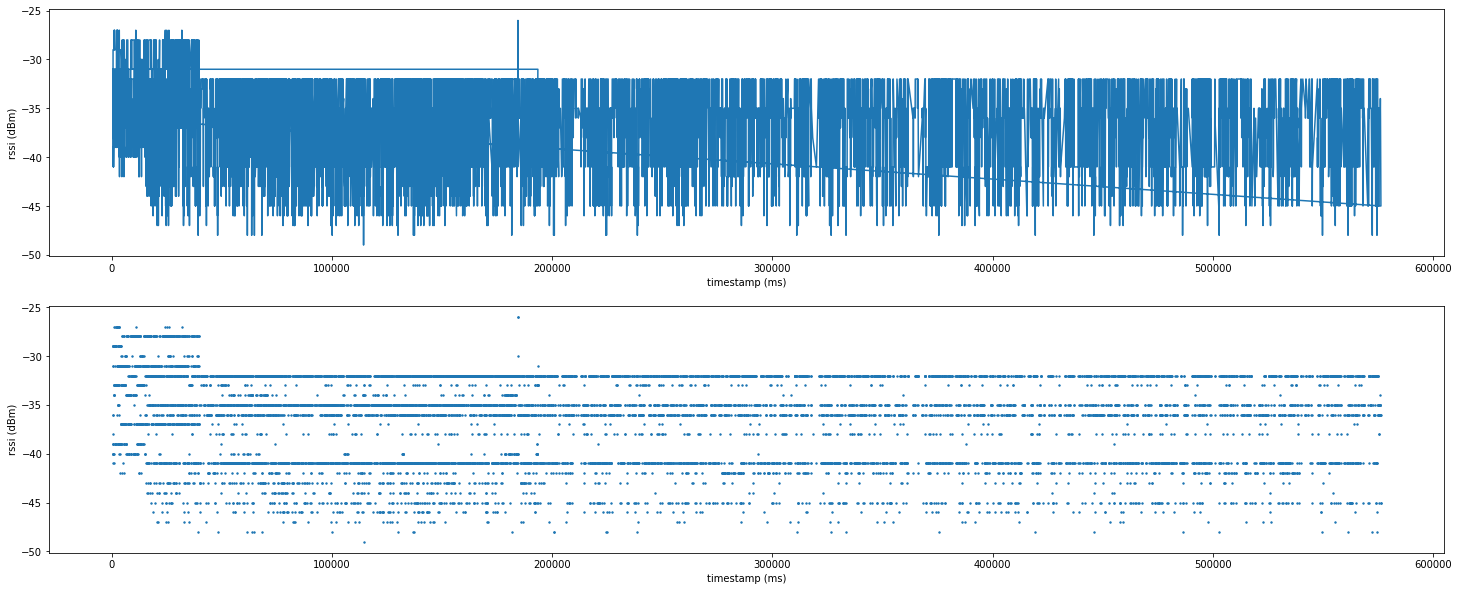

In [33]:
df_sample = df[:13000 ]
plt.figure(figsize=(25,10))
plt.subplot(211)
plt.plot(df_sample['timestamp'], df_sample['rssi'], linestyle='-')
plt.xlabel('timestamp (ms)')
plt.ylabel('rssi (dBm)')
plt.subplot(212)
plt.scatter(df_sample['timestamp'], df_sample['rssi'], s=2)
plt.xlabel('timestamp (ms)')
plt.ylabel('rssi (dBm)')
plt.show()

##### Observation
* **RSSI over time** is highly **unstable**. 
* The **distribution** of RSSI in a small time windows is **stable**!
* The distribution show multiple stable line across time, this might indicates there is multipath effect exist.

##### Question
* This mean the RSSI raw value already be **averaged out during sampling** in lower network layer. But why is the RSSI is so unstable even already been averaged?

##### REFERENCE
[1] “802.15.4-2020 - IEEE Standard for Low-Rate Wireless Networks.” (2020). IEEE.    
[2] cc2420 2.4 GHz IEEE 802.15.4 / ZigBee-Ready RF Transceiver datasheet https://www.ti.com/lit/ds/symlink/cc2420.pdf  

According to [1]
> ##### 6.16.2.8 Received Signal Strength Indicator (RSSI)
> The RSSI is a **measurement of the RF power** in dBm for the received packet.   
> The RF power level at the input of the transceiver **measured during the PHR(Power Headroom Report 功率余量?)** and is valid after the start-of-frame delimiter is deteced.
>
> ##### 10.2.6 Receiver ED (energy detection)
> The Receiver ED **estimate of the received signal power** within the bandwidth of the channel.    
> The ED **measurement time**, to average over, shall be equal to **8 symbol periods**.

Corresponding to the description in [2]:
> ##### 23 RSSI/Energy Detection
> The **RSSI value is always averaged over 8 symbol periods (128 μs)**.

### Plot Distribution Data over Time

To estimate the distribution with in a small sampling period, we move a time window across the dataset.

In [34]:
SAMPLE_WINDOW = 2000
MAX_RSSI = 0
MIN_RSSI = -99
SAMPLE_SIZE = len(df_sample)

##### Calculate Distribution Over Time

In [35]:
pdf_seq = []

def to_sparse(inp):
    out = np.zeros(MAX_RSSI - MIN_RSSI + 1)
    for key in inp.keys():
        if key > 0:
            out[0] += inp[key]
        elif key < -99:
            out[99] += inp[key]
        else:
            index = np.abs(key)
            out[index] += inp[key]
    return out
        
for index in range(SAMPLE_SIZE):
    pdf = {}
    start_time = df_sample.iloc[index].timestamp
    
    rssis = df_sample[(df_sample.timestamp < start_time + SAMPLE_WINDOW) & (df_sample.timestamp >= start_time)].rssi.to_numpy()
    for rssi in rssis:
        if rssi in pdf:
            pdf[rssi] += 1
        else:
            pdf[rssi] = 1
    pdf_seq.append(to_sparse(pdf))
    
pdf_seq = np.array(pdf_seq)

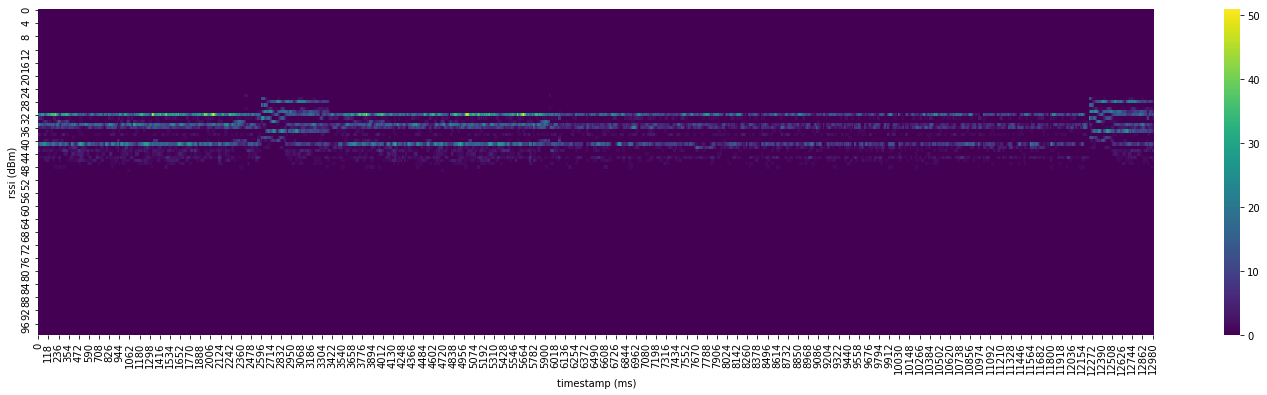

In [36]:
plt.figure(figsize=(25,6))
ax = sns.heatmap(pdf_seq.transpose(1,0),cmap="viridis")
plt.xlabel('timestamp (ms)')
plt.ylabel('rssi (dBm)')
plt.show()

In [37]:
def plot_pdf(pdf):
    fig, ax = plt.subplots(figsize=(25,6))
    x_labels = np.arange(MAX_RSSI, MIN_RSSI-1, -1)
    plt.bar(x_labels, pdf)
    plt.xlabel('rssi (dBm)')
    plt.ylabel('count')
    plt.xticks(np.arange(MAX_RSSI, MIN_RSSI-1, step=-2))
    ax.invert_xaxis()
    plt.show()

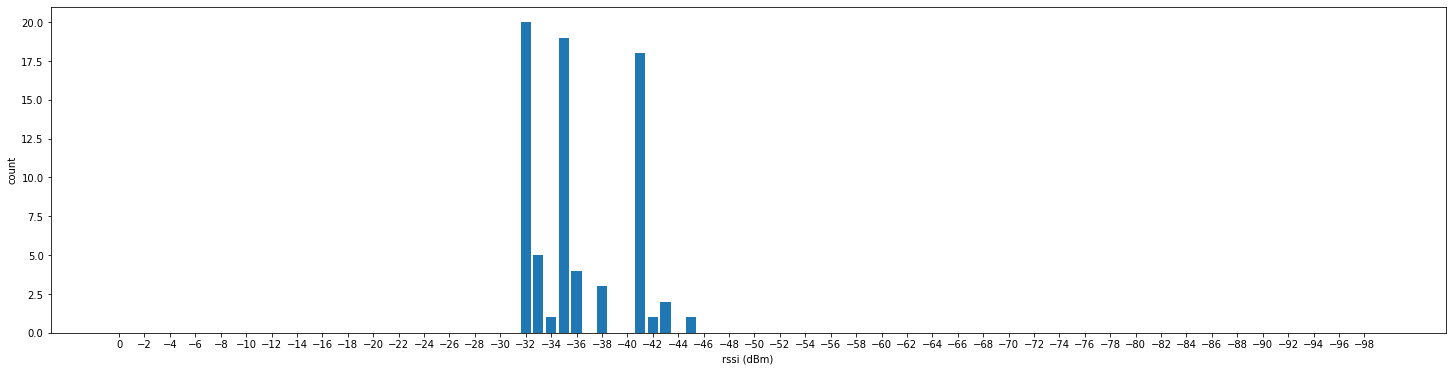

Frame 19


In [38]:
for i in range(20):
    if i >= len(pdf_seq):
        break
    plot_pdf(pdf_seq[i])
    print(f"Frame {i}")
    IPython.display.clear_output(wait = True)
    

##### Observation

The probability distribution on different path seems has similar weight? why?

In [39]:
pdf_seq.shape

(13000, 100)

### Speed

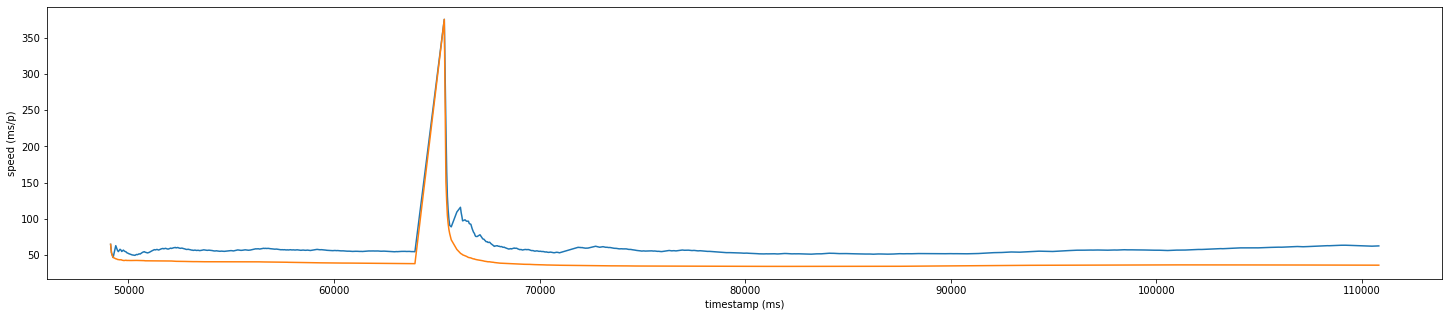

In [53]:
df_sample = df[:1000]
plt.figure(figsize=(25,5))
plt.plot(df_sample['timestamp'], df_sample['rx_speed'], linestyle='-')
plt.plot(df_sample['timestamp'], df_sample['tx_speed'], linestyle='-')
# plt.plot(df_sample['timestamp'], df_sample['last_time_elapsed'], linestyle='-', c='g', alpha=0.1)
plt.xlabel('timestamp (ms)')
plt.ylabel('speed (ms/p)')
plt.show()